# Generate Figure 2: GPA

In [1]:
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.io import imread

import colorcet


import scipy.ndimage as ndi

from moisan2011 import per
from pyGPA.imagetools import fftplot, gauss_homogenize2, gauss_homogenize3, trim_nans
import pyGPA.geometric_phase_analysis as GPA
import pyGPA.property_extract as pe

from skimage.segmentation import watershed
import skimage.morphology as morpho
from skimage.filters import gaussian
from skimage.measure import regionprops, label

import matplotlib as mpl
from matplotlib import ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
glasbey = plt.get_cmap('cet_glasbey_dark')(np.linspace(0, 1, 255))


def select_large_areas(labeling, threshold=5000):
    lbl = labeling
    nlbl = np.zeros_like(lbl)
    rprops = regionprops(lbl)
    #print([prop.area for prop in rprops if prop.area > 5000])
    i = 1
    for prop in rprops:
        if prop.area > threshold:
            nlbl[lbl == prop.label] = i
            i += 1
    return nlbl

In [3]:
folder = 'data'
name = '20200713_163811_5.7um_501.2_sweep-STAGE_X-STAGE_Y_domainboundaries_stitch_v10_2020-11-20_1649_sobel_4_bw_200.tif'
NMPERPIXEL = 3.7

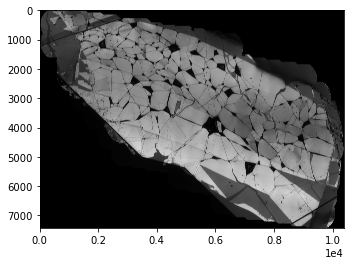

In [4]:
image = imread(os.path.join(folder, name)).squeeze()
plt.imshow(image, cmap='gray')

In [5]:
coords = np.array([[3642.89786153, 5400.49488182],
                   [3721.72436096, 6384.55472946],
                   [3507.55425954, 8281.36876338],
                   [3380.03002363, 6921.11024705],
                   [4187.6835177, 6938.49991558],
                   [3807.04299538, 7066.02415149],
                   [4812.93836045, 7729.48655758],
                   [4099.87750689, 9225.98507689],
                   [850.69462839, 4398.48610047],
                   [363.96565178, 1325.27028875],
                   [4271.33017045, 7833.81755442],
                   [2735.31323933, 4710.03264254]])

/home/tobias/anaconda3/envs/moire-figures/lib/python3.8/site-packages/pyGPA/imagetools.py:97: RuntimeWarning: invalid value encountered in true_divide
  VV /= ndi.gaussian_filter(mask.astype(image.dtype),


(1000, 1000) 10 9 5
(1000, 1000) 6 5 4
(1000, 1000) 7 6 3
(1000, 1000) 4 3 3
(1000, 1000) 3 2 5
(1000, 1000) 10 9 2
(1000, 1000) 7 6 5
(1000, 1000) 12 11 5
(1000, 1000) 7 6 0
(1001, 1000) 11 10 0
(1000, 1000) 6 5 4
(1000, 1000) 12 11 3


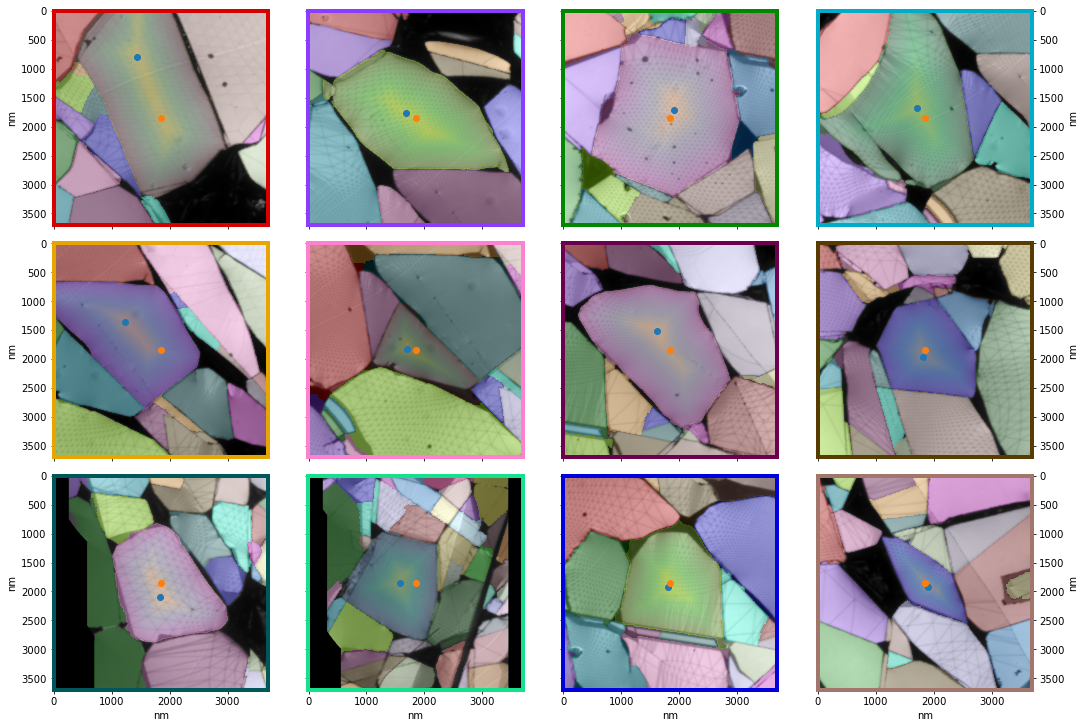

In [6]:
fig, axs = plt.subplots(3, 4, figsize=[15, 10], constrained_layout=True, sharex=True, sharey=True)
axs = axs.flat
s = 500
sprimes = []
bbox_images = []
regions = []
full_crops = []
all_dists = []
for i, coord in enumerate(coords):
    x = slice(max(int(coord[0])-s, 0), int(coord[0])+s)
    y = slice(max(int(coord[1])-s, 0), int(coord[1])+s)
    lim = image[x, y]
    if lim.shape[0] != 2*s:
        lim = np.pad(lim, ((s-lim.shape[0]//2, s-lim.shape[0]//2), (0, 0)))
    full_crops.append(lim)
    clip = np.clip(lim, *np.quantile(lim[lim > 0], [0.05, 0.9999]))
    dclip = (clip / gaussian(clip, 50)) >= 0.9
    ero = morpho.binary_erosion(dclip, selem=morpho.disk(5))
    mask2 = morpho.remove_small_holes(ero, 25**2)
    nextone = morpho.binary_erosion(gauss_homogenize3(clip, mask2,  25) > 0.91, selem=morpho.disk(8))
    labeling = label(nextone)
    llabels = select_large_areas(labeling, threshold=200)
    #labelim = np.where(llabels == 0, np.nan, llabels)
    # 1e4 is determined from histograms of images. Maybe use Otsu's methods instead?
    wres = watershed(-(gauss_homogenize3(clip, mask2,  15)), llabels, mask=clip > 1e4)
    if wres[0].max() == 0:
        region = regionprops(wres, intensity_image=lim)[wres[s, s]-2]
    else:
        region = regionprops(wres, intensity_image=lim)[wres[s, s]-1]
    regions.append(region)
    print(wres.shape, wres[s, s]+1, region.label, wres[0].max())
    dists = ndi.distance_transform_cdt(morpho.remove_small_holes(wres == wres[s, s], 25**2), metric='chessboard')
    all_dists.append(dists)
    sprimes.append(dists[s, s])
    bbox_images.append(lim[region.slice])
    coord = np.unravel_index(np.argmax(dists), dists.shape)
    axs[i].scatter(coord[0]*NMPERPIXEL, coord[1]*NMPERPIXEL)
    axs[i].scatter(s*NMPERPIXEL, s*NMPERPIXEL)

    im = axs[i].imshow(lim.T, vmax=np.quantile(lim, 0.999),
                       vmin=np.quantile(lim, 0.001), cmap='gray')
    im.set_extent(np.array(im.get_extent())*NMPERPIXEL)
    im = axs[i].imshow(
        np.where(
            wres == 0,
            np.nan,
            wres).T-0.5,
        cmap='cet_glasbey_bw_minc_20',
        interpolation='nearest',
        alpha=0.3,
        vmax=256,
        vmin=0)
    im.set_extent(np.array(im.get_extent())*NMPERPIXEL)
    im = axs[i].imshow(np.where(dists > 0, dists, np.nan).T, alpha=0.2)
    #im = axs[i].imshow(np.where(clip>clip.min()*1.2, 1, np.nan).T)
    im.set_extent(np.array(im.get_extent())*NMPERPIXEL)
    if i > 7:
        axs[i].set_xlabel('nm')
    if i % 4 == 0:
        axs[i].set_ylabel('nm')
    if i % 4 == 3:
        axs[i].yaxis.tick_right()
        axs[i].set_ylabel('nm')
        axs[i].yaxis.set_label_position("right")
        axs[i].tick_params(axis='y', which='both', labelleft=False, labelright=True)
    for axis in ['top', 'bottom', 'left', 'right']:
        axs[i].spines[axis].set_linewidth(4)
        axs[i].spines[axis].set_color(glasbey[i])
sprimes = np.array(sprimes)
#plt.savefig('crops.pdf', interpolation='none')

In [7]:
thetas = []
kvec_lists = []
d = 20
for i, coord in enumerate(coords):
    x = slice(int(coord[0])-sprimes[i]+d, int(coord[0])+sprimes[i]-d)
    y = slice(int(coord[1])-sprimes[i]+d, int(coord[1])+sprimes[i]-d)
    lim = image[x, y].astype(np.float64)
    pks, _ = GPA.extract_primary_ks(gauss_homogenize2(lim, np.ones_like(lim), 50),
                                    pix_norm_range=(4, 50), plot=False, threshold=0.7, sigma=1.5)
    if i == 0:
        print(pks)
        pks[2] = pks[0]-pks[1]
    props = pe.Kerelsky_plus(pks, nmperpixel=NMPERPIXEL, sort=1)
    print("props:", pe.Kerelsky_plus(pks, nmperpixel=NMPERPIXEL, sort=1)[0])
    kvec_lists.append(pks)
    thetas.append(props[0])
    print(thetas[-1])

[[ 0.02614379 -0.0130719 ]
 [ 0.00326797 -0.04575163]
 [ 0.05228758 -0.02614379]]
props: 0.12239099751809586
0.12239099751809586
props: 0.16404771119500933
0.16404771119500933
props: 0.17986711306069955
0.17986711306069955
props: 0.26051180009416053
0.26051180009416053
props: 0.6161634464470557
0.6161634464470557
props: 0.6283418926496198
0.6283418926496198
props: 0.3157508448259921
0.3157508448259921
props: 0.45981772941508103
0.45981772941508103
props: 0.08142903502024586
0.08142903502024586
props: 0.42232176576686187
0.42232176576686187
closest triangle: [[-0.          0.05902778]
 [ 0.06944444  0.04513889]
 [ 0.07291667  0.03472222]
 [ 0.06597222 -0.01041667]]
props: 0.22391518579909195
0.22391518579909195
props: 0.26834259438008967
0.26834259438008967


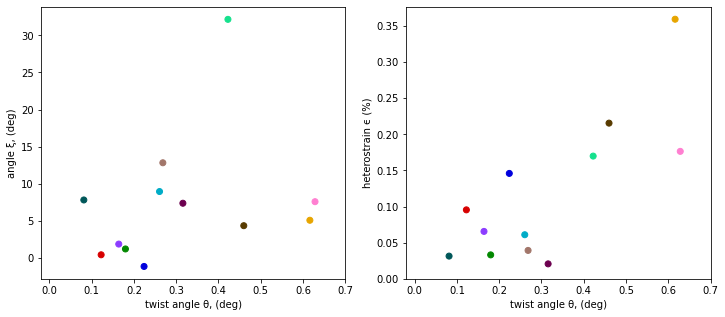

In [8]:
all_props = np.array([pe.Kerelsky_plus(pks, nmperpixel=NMPERPIXEL, sort=1) for pks in kvec_lists])
fig, ax = plt.subplots(ncols=2, figsize=[12, 5])

ax[0].scatter(all_props[:, 0], (all_props[:, 3]+25) %
              60 - 25, c=np.arange(all_props.shape[0]), cmap='cet_glasbey_dark', vmax=255)
ax[0].set_ylabel('angle ξ, (deg)')
ax[0].set_xlabel('twist angle θ, (deg)')

ax[1].scatter(all_props[:, 0], all_props[:, 2]*100, c=np.arange(all_props.shape[0]), cmap='cet_glasbey_dark', vmax=255)
ax[1].set_ylabel('heterostrain ϵ (%)')
ax[1].set_xlabel('twist angle θ, (deg)')
ax[1].set_ylim(0, None)
for i in range(2):
    ax[i].set_xlim(-0.02, 0.7)

In [9]:
spm = np.min(sprimes)
sprimes, spm

(array([173, 166, 234, 166, 109,  78, 145, 132, 130,  94, 164,  78],
       dtype=int32),
 78)

In [10]:
sindices = np.argsort(thetas)
sdp = sprimes[sindices]
coordsl = coords[sindices]

In [11]:
cluster = LocalCluster(n_workers=10, threads_per_worker=2, memory_limit='2GB')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 20,Total memory: 18.63 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42661,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 18.63 GiB
Comm: tcp://127.0.0.1:33455,Total threads: 2
Dashboard: http://127.0.0.1:34215/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:45957,


In [12]:
i = 5
coord = coordsl[i]
pks = kvec_lists[sindices[i]]  # [:,::-1]
kw = np.linalg.norm(pks, axis=1).mean()/4
kstep = kw/3
sigma = max(10, 0.9/np.linalg.norm(pks, axis=1).min())
dr = int(np.ceil(3*sigma))
x = slice(int(coord[0])-sdp[i]-dr, int(coord[0])+sdp[i]+dr)
y = slice(int(coord[1])-sdp[i]-dr, int(coord[1])+sdp[i]+dr)
lim = image[x, y].astype(float)
mask = np.zeros_like(lim, dtype=bool)
drp = dr//3
mask[drp:-drp, drp:-drp] = True
mask2 = (all_dists[sindices[i]] > drp)[500-sdp[i]-dr:500+sdp[i]+dr, 500-sdp[i]-dr:500+sdp[i]+dr]
mask = np.logical_and(mask, mask2)
lim = gauss_homogenize2(lim, mask, sigma=sigma/1)
lim -= np.nanmean(lim)
lim = np.nan_to_num(lim)
mask3 = np.zeros_like(lim, dtype=bool)
mask3[dr:-dr, dr:-dr] = True
mask = mask3
gs = []
for pk in pks:
    g = GPA.wfr2_grad_opt(lim, sigma, pk[0]*1., pk[1]*1., kw=kw, kstep=kstep)
    gs.append(g)


phases = np.stack([np.angle(g['lockin']) for g in gs])
maskzero = 0.000001
weights = np.stack([np.abs(g['lockin']) for g in gs])*(mask+maskzero)
grads = np.stack([g['grad'] for g in gs])

unew = GPA.reconstruct_u_inv_from_phases(pks, phases, weights)
uwi = GPA.invert_u_overlap(unew)

## New GPA top part

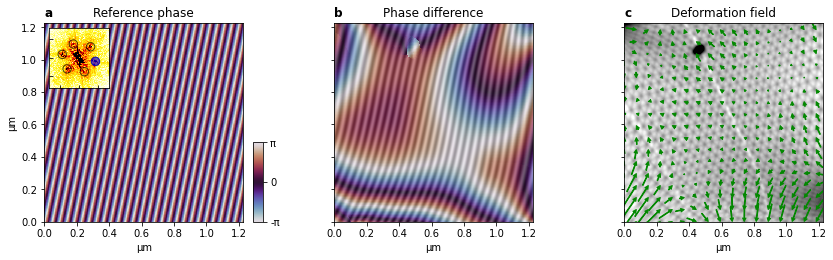

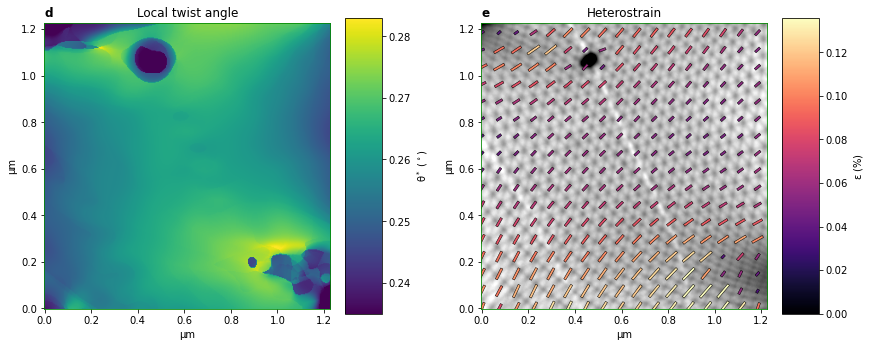

In [13]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=[12, 3.5],
                        constrained_layout=True, sharex=True, sharey=True)
fig2, axs2 = plt.subplots(ncols=2, nrows=1, figsize=[12, 4.8],
                          constrained_layout=True)
contours = False
j = 0
dx = pks[j][0] - gs[j]['w'][0]
dy = pks[j][1] - gs[j]['w'][1]
kx, ky = pks[j]
xx, yy = np.meshgrid(np.arange(lim.shape[0]), np.arange(lim.shape[1]), indexing='ij')
ref = np.exp(np.pi*2*1j*(xx*kx + yy*ky))
#im = axs[0,0].imshow(ref.real[dr:-dr,dr:-dr].T, origin='lower')
im = axs[0].imshow(np.angle(ref)[dr:-dr, dr:-dr], origin='lower',
                   cmap='twilight',
                   interpolation='none')
im.set_extent(np.array(im.get_extent())*NMPERPIXEL/1000)
#plt.colorbar(im, ax=axs[0])
caxins = inset_axes(axs[0],
                    width="5%",  # width = 5% of parent_bbox width
                    height="40%",  # height : 50%
                    loc='lower left',
                    bbox_to_anchor=(1.05, 0., 1, 1),
                    bbox_transform=axs[0].transAxes,
                    borderpad=0,
                    )
phasecbar = plt.colorbar(im, caxins, ticks=[-np.pi, 0, np.pi])  # , shrink=0.4, panchor=(1.0,1.0))
phasecbar.ax.set_yticklabels(['-π', '0', 'π'])

phase = np.exp(1j*np.angle(gs[j]['lockin']))
recon = ref / phase
recon = recon.real


p, _ = per(lim-lim.mean(), inverse_dft=False)
fftim = np.abs(np.fft.fftshift(p))
axin = inset_axes(axs[0], width="30%", height="30%", loc=2)
#axin.tick_params(labelleft=False, labelbottom=False, direction='in', length=0)
fftplot(fftim.T,
        ax=axin, pcolormesh=False,
        vmax=np.quantile(fftim, 0.998),
        vmin=np.quantile(fftim, 0.01),
        origin='lower',
        cmap='cet_fire_r', d=NMPERPIXEL, interpolation='none')
axin.scatter(*(pks/NMPERPIXEL).T[::-1]+0.5/NMPERPIXEL/s, edgecolor='black', alpha=0.7, s=70, marker='o', color='none')
axin.scatter(*(-pks/NMPERPIXEL).T[::-1]+0.5/NMPERPIXEL/s, edgecolor='black', alpha=0.7, s=70, marker='o', color='none')
axin.scatter(pks[j, 1]/NMPERPIXEL+0.5/NMPERPIXEL/s,
             pks[j, 0]/NMPERPIXEL+0.5/NMPERPIXEL/s,
             color='blue', s=70, alpha=0.6)
#indicate_k(pks/NMPERPIXEL, j, ax=axin, inset=False, origin='lower', s=20)
rf = 0.04
axin.set_xlim([rf, -rf])
axin.set_ylim([rf, -rf])
axin.tick_params(labelleft=False, labelbottom=False, direction='in')

im = axs[1].imshow(trim_nans(np.where(mask, np.angle(phase), np.nan)),
                   cmap='twilight',
                   interpolation='none', origin='lower')
im.set_extent(np.array(im.get_extent())*NMPERPIXEL/1000)
im = axs[1].imshow(recon[dr:-dr, dr:-dr], origin='lower',
                   cmap='gray', alpha=0.3,
                   extent=im.get_extent())


im = axs[2].imshow(image[x, y].astype(float)[dr:-dr, dr:-dr],
                   cmap='gray', origin='lower',
                   vmin=np.quantile(image[x, y].astype(float)[dr:-dr, dr:-dr], 0.002),
                   vmax=np.quantile(image[x, y].astype(float)[dr:-dr, dr:-dr], 0.999),
                   )

a = 20
axs[2].quiver((yy[dr:-dr:a, dr:-dr:a]-dr)*NMPERPIXEL/1000,
              (xx[dr:-dr:a, dr:-dr:a]-dr)*NMPERPIXEL/1000,
              *-uwi[::-1, dr:-dr:a, dr:-dr:a],
              angles='xy', scale_units='xy', headwidth=5, ec=glasbey[2], linewidth=1, pivot='tip',
              scale=1000/NMPERPIXEL, color=glasbey[2])
extent = np.array(im.get_extent())*NMPERPIXEL / 1000
im.set_extent(extent)
for ax in axs:
    ax.set_xlabel('μm')
axs[0].set_ylabel('μm')
axs[0].set_title('Reference phase')
axs[1].set_title('Phase difference')
axs[2].set_title('Deformation field')

for ax in axs:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.2))

for ax in axs2:
    ax.set_xlabel('μm')
    ax.set_ylabel('μm')
if True:
    J = pe.phasegradient2J(pks, grads, weights, nmperpixel=NMPERPIXEL, iso_ref=False, sort=1)
    res, refest = pe.Kerelsky_J(J, pks, sort=1, nmperpixel=NMPERPIXEL)
    res = res.compute()
    res[..., 1] = res[..., 1] % 180
    res[..., 3] = res[..., 3] % 180
    props = np.moveaxis(res, -1, 0)[:, dr:-dr, dr:-dr]

#props = pe.calc_props_from_phasegradient(pks, grads, weights, nmperpixel=3.7)
#props = np.stack([p[dr:-dr,dr:-dr] for p in props])
im = axs2[0].imshow(props[0], origin="lower",
                    vmax=np.nanquantile(props[0], 0.9999),
                    vmin=0.235  # np.nanquantile(props[2], 0.01),
                    )
cbar = plt.colorbar(im, ax=axs2[0], label='$\\theta^*$ ($^\\circ$)', shrink=0.94)
if contours:
    CF = axs2[0].contour(props[0], levels=np.linspace(0.225, 0.275, 40),
                         origin="lower",
                         extent=extent, colors='white', alpha=0.5, linewidth=0.5
                         )
im.set_extent(extent)
if contours:
    cbar.add_lines(CF)


im = axs2[1].imshow(image[x, y].astype(float)[dr:-dr, dr:-dr],
                    cmap='gray', origin='lower',
                    vmin=np.quantile(image[x, y].astype(float)[dr:-dr, dr:-dr], 0.002),
                    vmax=np.quantile(image[x, y].astype(float)[dr:-dr, dr:-dr], 0.999),
                    )

epscolor = props[2]*100
angle = np.deg2rad(props[1])  # % 180
magnitude = epscolor
#angle = np.deg2rad(props[1])
#magnitude = (props[3] - 1)
kx = magnitude*np.cos(angle)
ky = magnitude*np.sin(angle)
a = 20


if contours:
    CF = axs2[1].contour(props[2]*100, levels=np.linspace(0.0, 0.13, 52),
                         origin="lower",
                         extent=extent, colors='k', alpha=0.5, linewidth=0.5
                         )
Q = axs2[1].quiver((yy[dr:-dr:a, dr:-dr:a]-dr)*NMPERPIXEL/1000,
                   (xx[dr:-dr:a, dr:-dr:a]-dr)*NMPERPIXEL/1000,
                   kx[::a, ::a],
                   ky[::a, ::a],
                   np.clip(epscolor[::a, ::a], 0, np.quantile(epscolor, 0.985)),
                   cmap='magma',
                   norm=mpl.colors.Normalize(vmin=0),
                   angles='xy', scale_units='xy',
                   width=0.008, pivot='mid',
                   ec='black', linewidth=0.5,
                   headlength=0., headwidth=0.5, headaxislength=0)
cbar = plt.colorbar(Q, ax=axs2[1], label='$\\epsilon$ (%)', shrink=0.94)
im.set_extent(np.array(im.get_extent()) * NMPERPIXEL/1000)
if contours:
    cbar.add_lines(CF)
axs2[0].set_title('Local twist angle')
axs2[1].set_title('Heterostrain')

for l, ax in zip('abc', axs):
    ax.set_title(l, loc='left', fontweight='bold')
for l, ax in zip('de', axs2):
    ax.set_title(l, loc='left', fontweight='bold')
    for axis in ['top', 'bottom', 'left', 'right']:
        # ax.spines[axis].set_linewidth(1)
        ax.spines[axis].set_color(glasbey[2])

fig.savefig(os.path.join('figures', 'GPA_top_2_0.pdf'))
fig2.savefig(os.path.join('figures', 'GPA_center_eps_contour2_0.pdf'))

In [14]:
allprops = []
ayes = [3, 5, 7, 8, 9, 10, 11]
for i in ayes:
    coord = coordsl[i]
    pks = kvec_lists[sindices[i]]
    kw = np.linalg.norm(pks, axis=1).mean()/4
    kstep = kw/3
    sigma = max(10, 0.9/np.linalg.norm(pks, axis=1).min())
    dr = int(np.ceil(3*sigma))
    x = slice(int(coord[0])-sdp[i]-dr, int(coord[0])+sdp[i]+dr)
    y = slice(int(coord[1])-sdp[i]-dr, int(coord[1])+sdp[i]+dr)
    lim = image[x, y].astype(float)
    mask = np.zeros_like(lim, dtype=bool)
    drp = dr//3
    mask[drp:-drp, drp:-drp] = True
    mask2 = (all_dists[sindices[i]] > drp)[500-sdp[i]-dr:500+sdp[i]+dr, 500-sdp[i]-dr:500+sdp[i]+dr]
    mask = np.logical_and(mask, mask2)
    lim = gauss_homogenize2(lim, mask, sigma=sigma/1)
    lim -= np.nanmean(lim)
    lim = np.nan_to_num(lim)
    mask3 = np.zeros_like(lim, dtype=bool)
    mask3[dr:-dr, dr:-dr] = True
    mask = mask3
    gs = []
    for pk in pks:
        g = GPA.wfr2_grad_opt(lim, sigma, pk[0]*1., pk[1]*1., kw=kw, kstep=kstep)
        gs.append(g)

    phases = np.stack([np.angle(g['lockin']) for g in gs])
    maskzero = 0.000001
    weights = np.stack([np.abs(g['lockin']) for g in gs])*(mask+maskzero)
    grads = np.stack([g['grad'] for g in gs])

    J = pe.phasegradient2J(pks, grads, weights, nmperpixel=NMPERPIXEL, iso_ref=False, sort=1)
    stride = 1
    res, refest = pe.Kerelsky_J(J[::stride, ::stride], pks, sort=1, nmperpixel=NMPERPIXEL)
    res = res.compute()
    res[..., 1] = res[..., 1] % 180
    res[..., 3] = res[..., 3] % 180
    props = np.moveaxis(res, -1, 0)
    props = np.stack([p[dr//stride:-dr//stride, dr//stride:-dr//stride] for p in props])
    allprops.append(props)

/home/tobias/anaconda3/envs/moire-figures/lib/python3.8/site-packages/pyGPA/imagetools.py:97: RuntimeWarning: invalid value encountered in true_divide
  VV /= ndi.gaussian_filter(mask.astype(image.dtype),
/home/tobias/anaconda3/envs/moire-figures/lib/python3.8/site-packages/pyGPA/imagetools.py:97: RuntimeWarning: invalid value encountered in true_divide
  VV /= ndi.gaussian_filter(mask.astype(image.dtype),


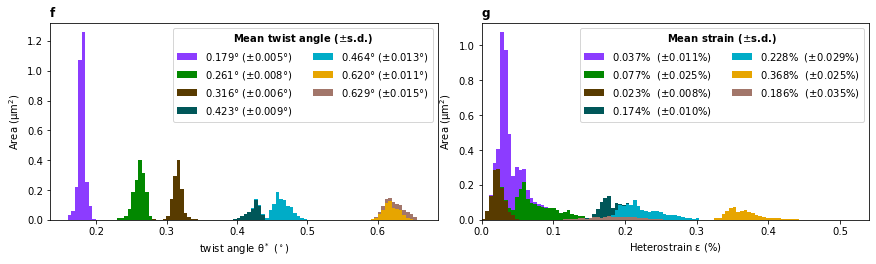

In [15]:
angles = [p[0].ravel() for p in allprops]
epsilons = [100*p[2].ravel() for p in allprops]
histfig, histaxs = plt.subplots(ncols=2, figsize=[12, 3.5])
# Hacking colors together to make consistent with  Fig 1
colors = glasbey[ayes]
colors[1] = glasbey[2]
colors[0] = glasbey[1]
colors[4] = glasbey[3]
colors[5] = glasbey[4]
histaxs[0].hist(angles, bins=100,
                color=colors, stacked=True,
                label=[f'{x.mean():.3f}° ($\\pm ${x.std():.3f}°)' for x in angles],
                weights=[np.full_like(p, (NMPERPIXEL/1e3)**2) for p in angles]
                )
histaxs[1].hist(epsilons[::-1], bins=100,
                color=colors[::-1], stacked=True,
                label=[f'{x.mean():.3f}%  ($\\pm ${x.std():.3f}%)' for x in epsilons[::-1]],
                weights=[np.full_like(p, (NMPERPIXEL/1e3)**2) for p in epsilons[::-1]]
                )

lgd = histaxs[0].legend(ncol=2)
lgd.set_title('Mean twist angle ($\\pm $s.d.)',
              prop=mpl.font_manager.FontProperties(weight='bold'))
histaxs[0].set_xlabel('twist angle $\\theta^*$ ($^\\circ$)')
handles, labels = histaxs[1].get_legend_handles_labels()
lgd = histaxs[1].legend(handles[::-1], labels[::-1],
                        ncol=2)
lgd.set_title('Mean strain ($\\pm $s.d.)',
              prop=mpl.font_manager.FontProperties(weight='bold'))
histaxs[1].set_xlabel('Heterostrain $\\epsilon$ (%)')
histaxs[1].set_xlim(0, None)
for l, ax in zip('fg', histaxs):
    ax.set_title(l, loc='left', fontweight='bold')
    ax.set_ylabel('Area (μm$^2$)')
plt.tight_layout(pad=0.1)
if stride == 1:
    histfig.savefig(os.path.join('figures', 'GPA_bottom_2_0.pdf'))